<a href="https://colab.research.google.com/github/AntoineGjn/GU-ou-pas-GU/blob/master/GU_ou_pas_GU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GU ou pas GU


### Introduction

I made a ConvNet learn the polytechnique GU using only 50 pictures,  most of them from the 14th July parade.

It might seems very hard at first to 'train' a network with a dataset so small but in pratice very few people actually train ConvNets from scratch. 
Instead, it is common to pretrain a ConvNet on a very large dataset (e.g. ImageNet, which contains 1.2 million images with 1000 categories), and then use the ConvNet either as an initialization or a fixed feature extractor for the task of interest.

The technique employed here is called 'Transfert Learning'

### Preparation

The following is pretty standard procedure.

One thing to notice is that since we will be using a pretrained ResNet-18, we need to resize and normalize the images accordingly. 

In [0]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')



Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
data_dir = 'gdrive/My Drive/Colab Notebooks/data/gu_data'

In [0]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Here we can visualize our training set :

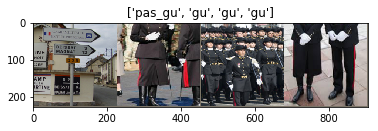

In [50]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

### Training and visualising

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [0]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            

            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            sm = torch.nn.Softmax()

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Now the interesting part 

### Heuristics

Now we have two options : we can either use the ConvNet as a fixed features extractor or we can fine-tune it

The thing is,  since our new dataset is very small (~50 images) it might not be a very good idea to fine-tune the whole network because of overfitting

Also, since  the data is similar to the original data, we expect higher-level features in the ConvNet to be relevant to this dataset as well. Hence, the best idea might be to train a linear classifier on top of it

### ConvNet as fixed feature extractor

First we are going to train the ConvNet as fixed feature extractor

In [0]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [11]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6590 Acc: 0.6429
val Loss: 0.6136 Acc: 0.7273

Epoch 1/24
----------
train Loss: 0.4847 Acc: 0.7245
val Loss: 0.6133 Acc: 0.6818

Epoch 2/24
----------
train Loss: 0.4917 Acc: 0.7857
val Loss: 0.6018 Acc: 0.7273

Epoch 3/24
----------
train Loss: 0.3828 Acc: 0.8265
val Loss: 0.7150 Acc: 0.6364

Epoch 4/24
----------
train Loss: 0.3560 Acc: 0.8265
val Loss: 0.7326 Acc: 0.6364

Epoch 5/24
----------
train Loss: 0.4265 Acc: 0.8265
val Loss: 0.5664 Acc: 0.6818

Epoch 6/24
----------
train Loss: 0.2886 Acc: 0.8673
val Loss: 0.8903 Acc: 0.6364

Epoch 7/24
----------
train Loss: 0.3247 Acc: 0.8469
val Loss: 0.6060 Acc: 0.7273

Epoch 8/24
----------
train Loss: 0.2861 Acc: 0.8571
val Loss: 0.6840 Acc: 0.6364

Epoch 9/24
----------
train Loss: 0.3505 Acc: 0.8265
val Loss: 0.5737 Acc: 0.6818

Epoch 10/24
----------
train Loss: 0.3026 Acc: 0.8776
val Loss: 0.5296 Acc: 0.7273

Epoch 11/24
----------
train Loss: 0.3303 Acc: 0.8571
val Loss: 0.6405 Acc: 0.6364

Ep

#### Results

Let's visualise some of the results

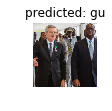

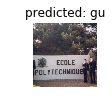

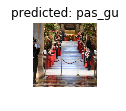

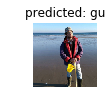

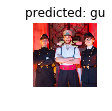

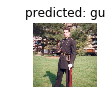

In [14]:
visualize_model(model_conv)

This is not so good as it leaves us with a ~50% accuracy on our validation set

### Fine-tuning the ConvNet

The use of the ConvNet as a fixed feature extractor was quite disapointing so let's fine tune it

In [0]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [52]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=100)

Epoch 0/99
----------
train Loss: 0.5808 Acc: 0.6633
val Loss: 0.6406 Acc: 0.6818

Epoch 1/99
----------
train Loss: 0.6846 Acc: 0.7245
val Loss: 0.5450 Acc: 0.7727

Epoch 2/99
----------
train Loss: 0.4443 Acc: 0.7959
val Loss: 0.6053 Acc: 0.8182

Epoch 3/99
----------
train Loss: 0.3952 Acc: 0.8265
val Loss: 0.4262 Acc: 0.7727

Epoch 4/99
----------
train Loss: 0.2075 Acc: 0.8878
val Loss: 0.5607 Acc: 0.7273

Epoch 5/99
----------
train Loss: 0.2538 Acc: 0.8776
val Loss: 1.1289 Acc: 0.6818

Epoch 6/99
----------
train Loss: 0.5099 Acc: 0.8265
val Loss: 0.7156 Acc: 0.6818

Epoch 7/99
----------
train Loss: 0.4746 Acc: 0.8265
val Loss: 0.7478 Acc: 0.7273

Epoch 8/99
----------
train Loss: 0.2272 Acc: 0.9184
val Loss: 0.6960 Acc: 0.7273

Epoch 9/99
----------
train Loss: 0.2559 Acc: 0.8878
val Loss: 0.6726 Acc: 0.7727

Epoch 10/99
----------
train Loss: 0.1720 Acc: 0.9286
val Loss: 0.5560 Acc: 0.7727

Epoch 11/99
----------
train Loss: 0.3816 Acc: 0.8265
val Loss: 0.7384 Acc: 0.7727

Ep

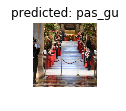

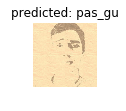

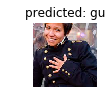

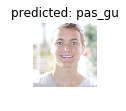

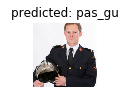

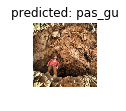

In [60]:
visualize_model(model_ft)

### Analyzing the results

This is way better

But there is still a concern : has the network learned the 'GU' or does it just learn the 'typical GU photo' (with the sky,  the faces,  or some other miscellaneous object)

To test this a method has been proposed by Matthew Zeiler in [Visualizing and Understanding Convolutional Networks](https://arxiv.org/abs/1311.2901)

To do this, we will be plotting the probability of the class of interest (e.g. GU class) as a function of the position of an occluder object. That is, we iterate over regions of the image, set a patch of the image to be all zero, and look at the probability of the class. We can visualize the probability as a 2-dimensional heat map.


#### Partial image occlusion

Let's try to 'fool' our net by taking an image where the colors and the background is different from the training set

To see if it recognise the GU or just a standing person let's take a pic of 3 persons standing

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 224, 224])


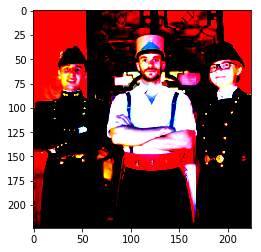

In [63]:
from PIL import *

def image_loader(loader, image_name):
    image = Image.open(image_name)
    image = loader(image).float()
    return image

transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])


im = image_loader(transform, data_dir + '/val/gu/34200294_962987713876093_3090082090180411392_n.jpg').detach()
plt.imshow(im.numpy().transpose(1,2,0))

print(im.shape)


Let's build a tensor of 'occluded pics'

In [0]:
results = torch.FloatTensor(169,3,224,224)

size_of_mask = 100
count =0;

for l in range(0,121,10):
  for p in range(0,121,10):
    mask = torch.ones(3,224,224)
   
    for i in range (l,l+size_of_mask):
      for j in range (p,p+size_of_mask):
        for k in range(3):
          mask[k][j][i] = 0
          
    results[count] = (mask*im).clone()
    count+=1

We can visualise it below in a grid. The occluding object is a square of side 100px

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


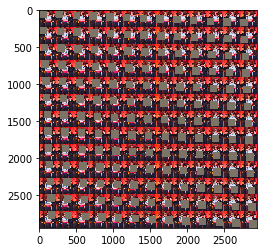

In [65]:
def imshow_example(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

plt.imshow(results[10].numpy().transpose(1,2,0))
out = torchvision.utils.make_grid(results, nrow = 13)
imshow_example(out)

Let's visualise the resulting heatmap :

torch.Size([169, 3, 224, 224])
torch.Size([169, 2])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':


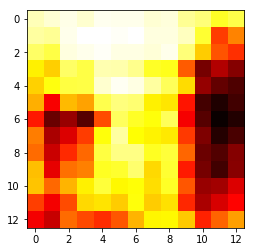

In [66]:
model_ft.eval()
inputs = results.to(device)
print(inputs.shape)
outputs = model_ft(inputs)
print(outputs.shape)
sm = torch.nn.Softmax()
  
heatmap = np.zeros(shape=(13,13))
count = 0
for i in range(13):
  for j in range(13):
    heatmap[j][i] = sm(outputs[count].cpu()).data[0].numpy()
    count+=1
plt.imshow(heatmap, cmap='hot', interpolation='nearest')
plt.show()

### Results 


So the probability of recognising the GU drops when the occluding object is centered on one of the two standing persons in GU and is very high when centered in the middle